In [37]:
import numpy as np
import matplotlib.pyplot as plt

import qutip as qt

import sim_utils as su

MHz = 1.0 # work in units of MHz
pi = np.pi

In [38]:
### system parameters
K = 2. * pi * 6. * MHz # Kerr nonlinearity
e_2 = 2. * pi * 15 * MHz # two-photon drive strength
e_x = 2. * pi * 6. * MHz
n_th = 0.04 # population of n=1 Fock state due to thermal noise
g_12 = 2. * pi * 1. * MHz #150.0e-3 * MHz
T_1 = 15.5 / MHz # single-photon decay time
kappa = 1. / T_1

### drive parameters
tau = 320.0e-3 / MHz # drive ramp time, ns

### simulation parameters
N = 10 # dimensionality of the Hilbert space, per resonator

### get the encoded basis states
psi_0, psi_1 = su.cat_states(K, e_2, N)

### get the gate durations
t_entangle, t_H_x_half, t_H_x_full, t_H_z_half = su.gate_durations(K, e_2, e_x, g_12)

### time at which to begin the sequence
t_start = 0.32/MHz

### define the Hamiltonian, now with coupling!
H = [su.H_kerr(K, N, nres=2, res_index=0),
     su.H_kerr(K, N, nres=2, res_index=1),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=0),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=1)]

t0 = t_start

H.append(su.H_entangle(K, e_2, g_12, N, t0=t0))
t0 += t_entangle

tmax = 1.2 * t0 # go until the sequence ends
dt = 1.0e-3 / MHz

In [40]:
t = np.arange(0., tmax, dt)

### initialize to a thermal state

rho_init_single = (1. - n_th) * qt.basis(N, 0) * qt.basis(N, 0).dag() + n_th * qt.basis(N, 1) * qt.basis(N, 1).dag()
rho_init = qt.tensor(rho_init_single, rho_init_single)

basis_states = su.basis(K, e_2, N)

bell_states = su.bell_states(K, e_2, N)

result = qt.mesolve(H, rho_init, t,
                    c_ops=[np.sqrt(kappa * (1. + n_th)) * qt.tensor(qt.destroy(N), qt.identity(N)),
                           np.sqrt(kappa * (1. + n_th)) * qt.tensor(qt.identity(N), qt.destroy(N)),
                           np.sqrt(kappa * n_th) * qt.tensor(qt.create(N), qt.identity(N)),
                           np.sqrt(kappa * n_th) * qt.tensor(qt.create(N), qt.identity(N))],
                    e_ops=[psi * psi.dag() for psi in basis_states + bell_states],
                    options=qt.Options(store_states=False, store_final_state=True))

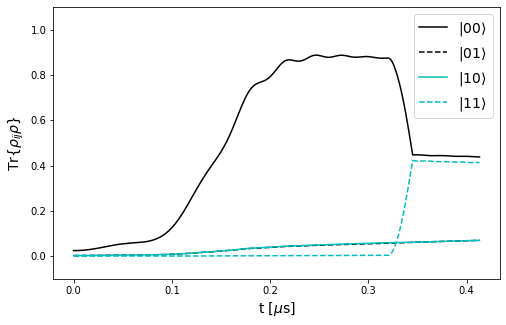

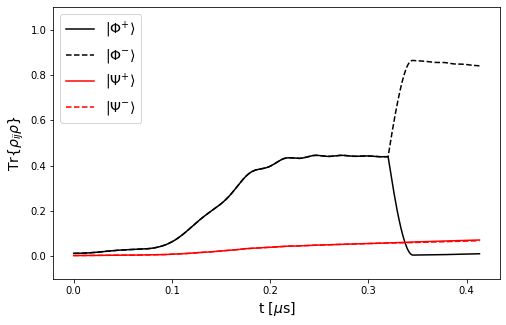

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(t * MHz, result.expect[0], color="black", label="$|00 \\rangle$")
plt.plot(t * MHz, result.expect[1], "--", color="black", label="$|01 \\rangle$")
plt.plot(t * MHz, result.expect[2], color="c", label="$|10 \\rangle$")
plt.plot(t * MHz, result.expect[3], "--", color="c", label="$|11 \\rangle$")
plt.legend(fontsize=14)
plt.xlabel("t [$\mu$s]", fontsize=14)
plt.ylabel("Tr{$\\rho_{ij} \\rho$}", fontsize=14)
plt.ylim(-0.1, 1.1)
plt.savefig("../figures/entangle1.png")

plt.figure(figsize=(8, 5))
plt.plot(t * MHz, result.expect[4], color="black", label="$| \Phi^{+} \\rangle$")
plt.plot(t * MHz, result.expect[5], "--", color="black", label="$| \Phi^{-} \\rangle$")
plt.plot(t * MHz, result.expect[6], color="red", label="$| \Psi^{+} \\rangle$")
plt.plot(t * MHz, result.expect[7], "--", color="red", label="$| \Psi^{-} \\rangle$")
plt.xlabel("t [$\mu$s]", fontsize=14)
plt.ylabel("Tr{$\\rho_{ij} \\rho$}", fontsize=14)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=14)
plt.savefig("../figures/entangle2.png")

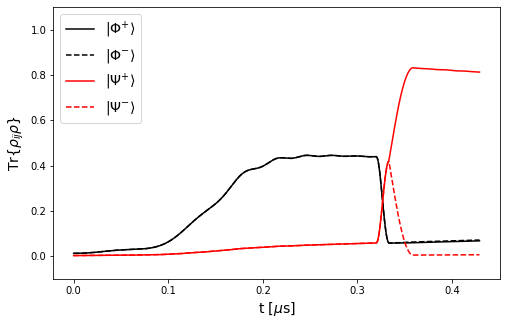

In [55]:
### define the Hamiltonian, now with coupling!
H = [su.H_kerr(K, N, nres=2, res_index=0),
     su.H_kerr(K, N, nres=2, res_index=1),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=0),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=1)]

t0 = t_start

H.append(su.H_x(K, e_2, e_x, N, t0, pi, nres=2, res_index=0))
t0 += t_H_x_full

H.append(su.H_entangle(K, e_2, g_12, N, t0=t0))
t0 += t_entangle

#H.append(su.H_x(K, e_2, e_x, N, t0, pi, nres=2, res_index=0))
#t0 += t_H_x_full

tmax = 1.2 * t0 # go until the sequence ends
dt = 1.0e-3 / MHz

t = np.arange(0., tmax, dt)

### initialize to a thermal state

rho_init_single = (1. - n_th) * qt.basis(N, 0) * qt.basis(N, 0).dag() + n_th * qt.basis(N, 1) * qt.basis(N, 1).dag()
rho_init = qt.tensor(rho_init_single, rho_init_single)

basis_states = su.basis(K, e_2, N)

bell_states = su.bell_states(K, e_2, N)

result = qt.mesolve(H, rho_init, t,
                    c_ops=[np.sqrt(kappa * (1. + n_th)) * qt.tensor(qt.destroy(N), qt.identity(N)),
                           np.sqrt(kappa * (1. + n_th)) * qt.tensor(qt.identity(N), qt.destroy(N)),
                           np.sqrt(kappa * n_th) * qt.tensor(qt.create(N), qt.identity(N)),
                           np.sqrt(kappa * n_th) * qt.tensor(qt.create(N), qt.identity(N))],
                    e_ops=[psi * psi.dag() for psi in basis_states + bell_states],
                    options=qt.Options(store_states=False, store_final_state=True))

plt.figure(figsize=(8, 5))
plt.plot(t * MHz, result.expect[4], color="black", label="$| \Phi^{+} \\rangle$")
plt.plot(t * MHz, result.expect[5], "--", color="black", label="$| \Phi^{-} \\rangle$")
plt.plot(t * MHz, result.expect[6], color="red", label="$| \Psi^{+} \\rangle$")
plt.plot(t * MHz, result.expect[7], "--", color="red", label="$| \Psi^{-} \\rangle$")
plt.xlabel("t [$\mu$s]", fontsize=14)
plt.ylabel("Tr{$\\rho_{ij} \\rho$}", fontsize=14)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=14)
plt.savefig("../figures/entangle3.png")

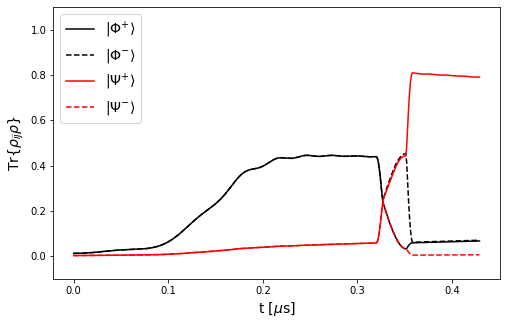

In [58]:
### define the Hamiltonian, now with coupling!
H = [su.H_kerr(K, N, nres=2, res_index=0),
     su.H_kerr(K, N, nres=2, res_index=1),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=0),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=1)]

t0 = t_start

#H.append(su.H_x(K, e_2, e_x, N, t0, pi, nres=2, res_index=0))
#t0 += t_H_x_full

H.append(su.H_x(K, e_2, e_x, N, t0, pi/2, nres=2, res_index=0))
t0 += t_H_x_half

H.append(su.H_entangle(K, e_2, g_12, N, t0=t0))
t0 += t_entangle

H.append(su.H_x(K, e_2, e_x, N, t0, pi/2, nres=2, res_index=0))
t0 += t_H_x_half

#H.append(su.H_x(K, e_2, e_x, N, t0, pi, nres=2, res_index=0))
#t0 += t_H_x_full

#H.append(su.H_x(K, e_2, e_x, N, t0, pi, nres=2, res_index=0))
#t0 += t_H_x_full

tmax = 1.2 * t0 # go until the sequence ends
dt = 1.0e-3 / MHz

t = np.arange(0., tmax, dt)

### initialize to a thermal state

rho_init_single = (1. - n_th) * qt.basis(N, 0) * qt.basis(N, 0).dag() + n_th * qt.basis(N, 1) * qt.basis(N, 1).dag()
rho_init = qt.tensor(rho_init_single, rho_init_single)

basis_states = su.basis(K, e_2, N)

bell_states = su.bell_states(K, e_2, N)

result = qt.mesolve(H, rho_init, t,
                    c_ops=[np.sqrt(kappa * (1. + n_th)) * qt.tensor(qt.destroy(N), qt.identity(N)),
                           np.sqrt(kappa * (1. + n_th)) * qt.tensor(qt.identity(N), qt.destroy(N)),
                           np.sqrt(kappa * n_th) * qt.tensor(qt.create(N), qt.identity(N)),
                           np.sqrt(kappa * n_th) * qt.tensor(qt.create(N), qt.identity(N))],
                    e_ops=[psi * psi.dag() for psi in basis_states + bell_states],
                    options=qt.Options(store_states=False, store_final_state=True))

plt.figure(figsize=(8, 5))
plt.plot(t * MHz, result.expect[4], color="black", label="$| \Phi^{+} \\rangle$")
plt.plot(t * MHz, result.expect[5], "--", color="black", label="$| \Phi^{-} \\rangle$")
plt.plot(t * MHz, result.expect[6], color="red", label="$| \Psi^{+} \\rangle$")
plt.plot(t * MHz, result.expect[7], "--", color="red", label="$| \Psi^{-} \\rangle$")
plt.xlabel("t [$\mu$s]", fontsize=14)
plt.ylabel("Tr{$\\rho_{ij} \\rho$}", fontsize=14)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=14)
plt.savefig("../figures/entangle4.png")